New Data Sources:

- Hypoxia: https://www.ncei.noaa.gov/maps/hypoxia/
- Corn/Soybeans: https://quickstats.nass.usda.gov
- Precipitation: https://www.ncei.noaa.gov/access/us-climate-normals/
- Wind: https://www.ndbc.noaa.gov/station_history.php?station=42040


# Hypoxia Data Availability Analysis
Analyzes spatial and temporal coverage of Gulf hypoxia measurements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
import requests
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration
DATA_DIR = Path('Data/hypoxia')
ZONE_BOUNDARIES = {
    'Zone 1 (Texas/Western)': (-180, -93),      # longitude < -93
    'Zone 2 (Louisiana Central)': (-93, -89),   # -93 to -89
    'Zone 3 (Eastern/Mississippi)': (-89, 180)  # longitude > -89
}

In [3]:
def assign_zone(longitude):
    """Assign a zone based on longitude"""
    if longitude < -93:
        return 'Zone 1 (Texas/Western)'
    elif longitude < -89:
        return 'Zone 2 (Louisiana Central)'
    else:
        return 'Zone 3 (Eastern/Mississippi)'

In [4]:
def load_year_data(year):
    """Load data for a specific year"""
    file_path = DATA_DIR / f'{year}.csv'
    if not file_path.exists():
        return None
    
    try:
        df = pd.read_csv(file_path)
        # Add zone assignment
        df['Zone'] = df['Longitude'].apply(assign_zone)
        df['Year'] = year
        return df
    except Exception as e:
        print(f"Error loading {year}: {e}")
        return None

In [5]:
all_data = []
available_years = []

for year in range(2001, 2025):
    df = load_year_data(year)
    if df is not None:
        all_data.append(df)
        available_years.append(year)
        
print(f"Found data for {len(available_years)} years")
print(f"  Years with data: {available_years}")
print(f"  Missing years: {set(range(2001, 2025)) - set(available_years)}")

# Combine all data
full_df = pd.concat(all_data, ignore_index=True)

Found data for 22 years
  Years with data: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2023, 2024]
  Missing years: {2020, 2022}


In [6]:
yearly_summary = []

for year in sorted(available_years):
    year_data = full_df[full_df['Year'] == year]
    
    summary = {
        'Year': year,
        'Total_Stations': len(year_data),
        'Zone1_Stations': len(year_data[year_data['Zone'] == 'Zone 1 (Texas/Western)']),
        'Zone2_Stations': len(year_data[year_data['Zone'] == 'Zone 2 (Louisiana Central)']),
        'Zone3_Stations': len(year_data[year_data['Zone'] == 'Zone 3 (Eastern/Mississippi)']),
        'Hypoxic_Stations': (year_data['Bottom_OxMgL'] < 2.0).sum(),
        'Mean_O2': year_data['Bottom_OxMgL'].mean(),
        'Min_O2': year_data['Bottom_OxMgL'].min(),
        'Date_Range': f"{year_data['DateUTC'].min()} to {year_data['DateUTC'].max()}"
    }
    yearly_summary.append(summary)

summary_df = pd.DataFrame(yearly_summary)
print(summary_df.to_string(index=False))

 Year  Total_Stations  Zone1_Stations  Zone2_Stations  Zone3_Stations  Hypoxic_Stations  Mean_O2  Min_O2             Date_Range
 2001              79              64              13               2                10 4.548270 0.09670 6/13/2001 to 7/25/2001
 2002             200             129              56              15                38 3.773560 0.06000  6/12/2002 to 7/9/2002
 2003             153             111              15              27                 7 5.143382 0.00000  6/11/2003 to 7/9/2003
 2004             217             139              78               0                30 4.281833 0.00000  6/17/2004 to 7/9/2004
 2005             179             116              49              14                21 4.712988 0.00000  6/15/2005 to 8/1/2005
 2006             230             128              78              24                16 4.844309 0.18921  6/14/2006 to 7/9/2006
 2007             168             106              46              16                31 3.872046 0.00263

In [7]:
coverage_matrix = summary_df.pivot_table(
    index='Year',
    values=['Zone1_Stations', 'Zone2_Stations', 'Zone3_Stations'],
    aggfunc='sum'
).fillna(0).astype(int)

coverage_matrix.columns = ['Zone 1', 'Zone 2', 'Zone 3']
print(coverage_matrix)

# Identify years with complete coverage (all zones have data)
complete_years = coverage_matrix[(coverage_matrix > 0).all(axis=1)].index.tolist()
print(f"\nYears with ALL zones covered: {len(complete_years)} years")
print(f"  {complete_years}")

# Identify years with partial coverage
partial_years = coverage_matrix[~(coverage_matrix > 0).all(axis=1)].index.tolist()
if partial_years:
    print(f"\nYears with MISSING zones: {len(partial_years)} years")
    print(f"  {partial_years}")
    print("\n  Details:")
    for year in partial_years:
        missing_zones = coverage_matrix.loc[year][coverage_matrix.loc[year] == 0].index.tolist()
        print(f"    {year}: Missing {missing_zones}")

      Zone 1  Zone 2  Zone 3
Year                        
2001      64      13       2
2002     129      56      15
2003     111      15      27
2004     139      78       0
2005     116      49      14
2006     128      78      24
2007     106      46      16
2008     129      78      15
2009     215     116      60
2010     124      28       0
2011     132      55       5
2012     142      42      96
2013     118      52      59
2014     140      83      40
2015     140      62      41
2016     150      69      59
2017     109      36      51
2018      83      29      21
2019      97      22      41
2021      84      26       1
2023       0      33      38
2024     103      18      31

Years with ALL zones covered: 19 years
  [2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2024]

Years with MISSING zones: 3 years
  [2004, 2010, 2023]

  Details:
    2004: Missing ['Zone 3']
    2010: Missing ['Zone 3']
    2023: Missing ['Z

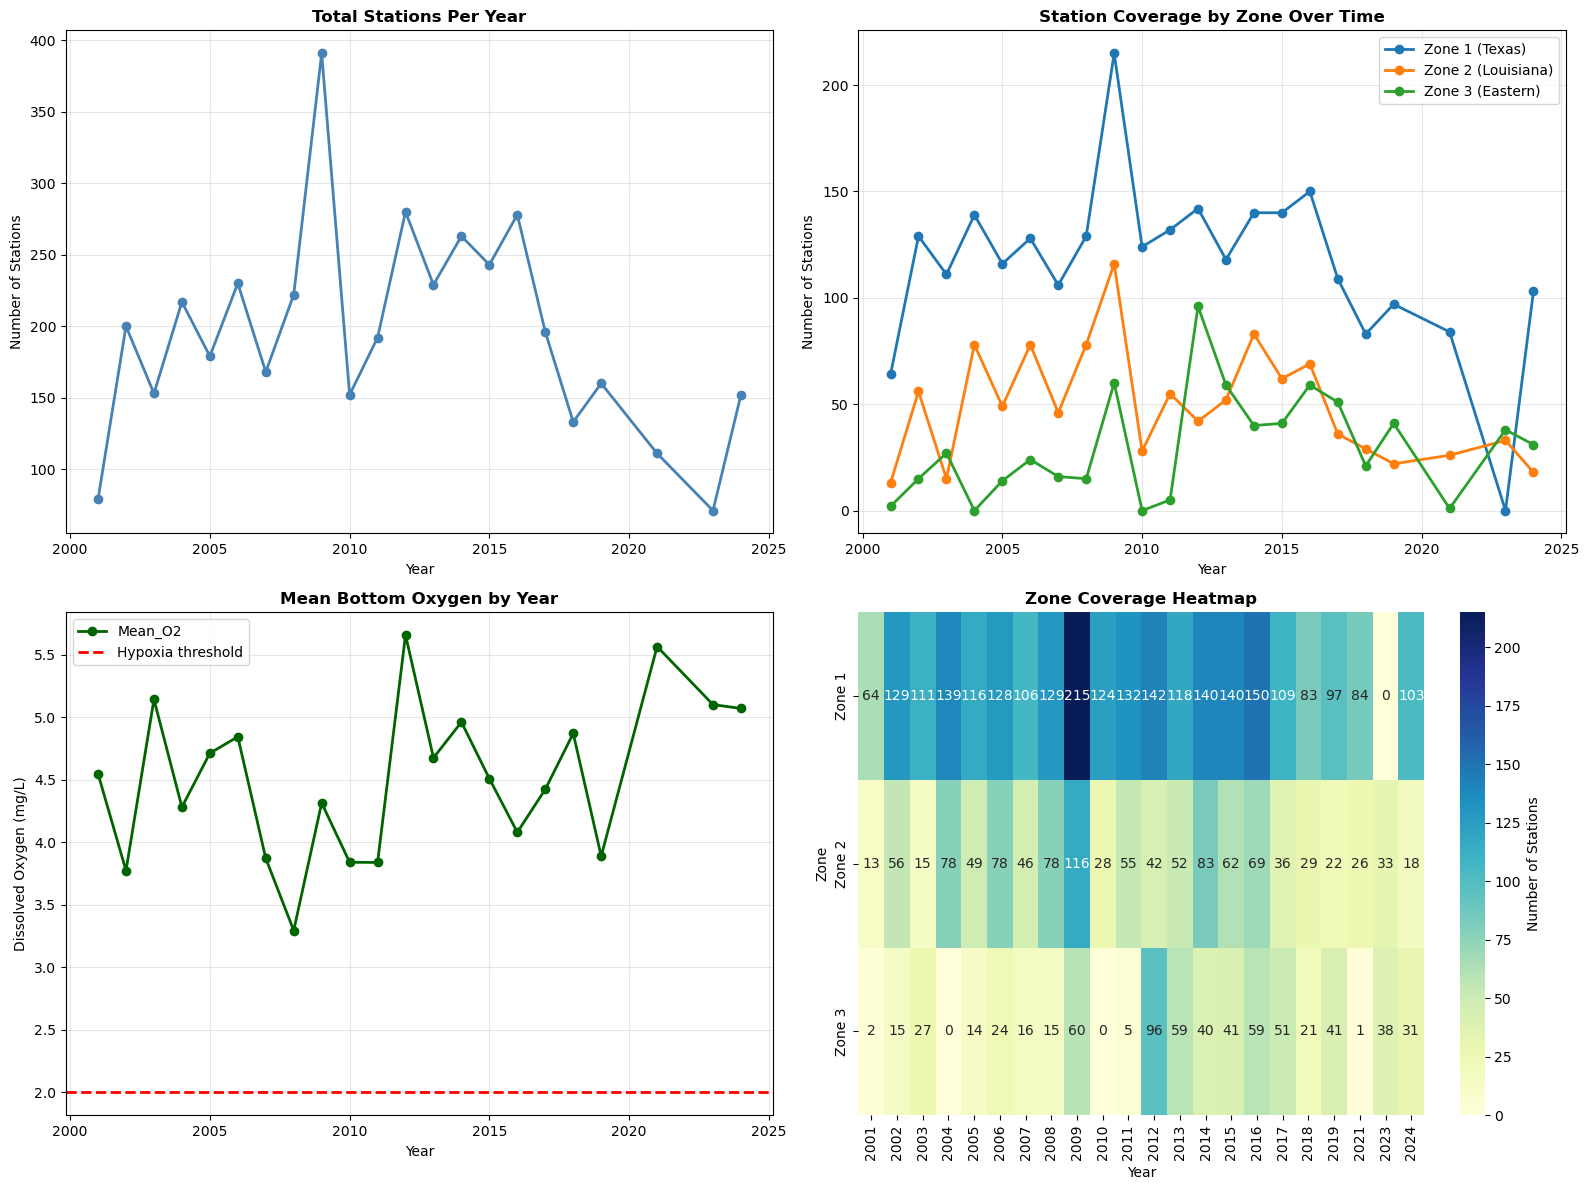

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Station counts by year
ax1 = axes[0, 0]
summary_df.plot(x='Year', y='Total_Stations', marker='o', ax=ax1, color='steelblue', linewidth=2)
ax1.set_title('Total Stations Per Year', fontsize=12, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Stations')
ax1.grid(True, alpha=0.3)
ax1.legend().remove()

# Plot 2: Stations by zone over time
ax2 = axes[0, 1]
summary_df.plot(x='Year', y=['Zone1_Stations', 'Zone2_Stations', 'Zone3_Stations'], 
                marker='o', ax=ax2, linewidth=2)
ax2.set_title('Station Coverage by Zone Over Time', fontsize=12, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Stations')
ax2.legend(['Zone 1 (Texas)', 'Zone 2 (Louisiana)', 'Zone 3 (Eastern)'])
ax2.grid(True, alpha=0.3)

# Plot 3: Mean oxygen levels over time
ax3 = axes[1, 0]
summary_df.plot(x='Year', y='Mean_O2', marker='o', ax=ax3, color='darkgreen', linewidth=2)
ax3.axhline(y=2, color='red', linestyle='--', linewidth=2, label='Hypoxia threshold')
ax3.set_title('Mean Bottom Oxygen by Year', fontsize=12, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Dissolved Oxygen (mg/L)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Coverage heatmap
ax4 = axes[1, 1]
sns.heatmap(coverage_matrix.T, annot=True, fmt='d', cmap='YlGnBu', 
            cbar_kws={'label': 'Number of Stations'}, ax=ax4)
ax4.set_title('Zone Coverage Heatmap', fontsize=12, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Zone')

plt.tight_layout()


# Aggregate Hypoxia Data by Zone and Year
Creates dataset with zone-level summary statistics

In [9]:
# Configuration
DATA_DIR = Path('Data/hypoxia')
OUTPUT_DIR = Path('Data/processed')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ZONE_BOUNDARIES = {
    'Zone1': (-180, -93),      # Texas/Western
    'Zone2': (-93, -89),       # Louisiana Central  
    'Zone3': (-89, 180)        # Eastern/Mississippi
}

HYPOXIA_THRESHOLD = 2.0  # mg/L

In [10]:
def assign_zone(longitude):
    """Assign zone based on longitude"""
    if longitude < -93:
        return 'Zone1'
    elif longitude < -89:
        return 'Zone2'
    else:
        return 'Zone3'

In [11]:
def estimate_area_km2(lons, lats, hypoxic_mask):
    """
    Estimate hypoxic area using triangulation within convex hull
    Returns area in km^2
    """
    if len(lons) < 3 or hypoxic_mask.sum() < 3:
        return 0.0
    
    # Convert to approximate km (rough approximation for Gulf)
    # At ~28°N latitude: 1° lon ≈ 96 km, 1° lat ≈ 111 km
    x = lons * 96
    y = lats * 111
    
    try:
        # Get hypoxic points
        hypoxic_x = x[hypoxic_mask]
        hypoxic_y = y[hypoxic_mask]
        
        if len(hypoxic_x) < 3:
            return 0.0
        
        # Create convex hull of hypoxic points
        points = np.column_stack([hypoxic_x, hypoxic_y])
        hull = ConvexHull(points)
        return hull.volume  # In 2D, volume is actually area
    except:
        return 0.0

In [12]:
def calculate_zone_metrics(df_zone):
    """Calculate comprehensive metrics for a zone"""
    if len(df_zone) == 0:
        return None
    
    metrics = {}
    
    # Basic oxygen statistics
    metrics['n_stations'] = len(df_zone)
    metrics['mean_O2'] = df_zone['Bottom_OxMgL'].mean()
    metrics['median_O2'] = df_zone['Bottom_OxMgL'].median()
    metrics['std_O2'] = df_zone['Bottom_OxMgL'].std()
    metrics['min_O2'] = df_zone['Bottom_OxMgL'].min()
    metrics['max_O2'] = df_zone['Bottom_OxMgL'].max()
    
    # Hypoxia metrics
    hypoxic_mask = df_zone['Bottom_OxMgL'] < HYPOXIA_THRESHOLD
    metrics['n_hypoxic'] = hypoxic_mask.sum()
    metrics['percent_hypoxic'] = (hypoxic_mask.sum() / len(df_zone)) * 100
    
    # Severe hypoxia (<1 mg/L)
    severe_mask = df_zone['Bottom_OxMgL'] < 1.0
    metrics['n_severe_hypoxic'] = severe_mask.sum()
    metrics['percent_severe_hypoxic'] = (severe_mask.sum() / len(df_zone)) * 100
    
    # Spatial extent
    metrics['lon_min'] = df_zone['Longitude'].min()
    metrics['lon_max'] = df_zone['Longitude'].max()
    metrics['lat_min'] = df_zone['Latitude'].min()
    metrics['lat_max'] = df_zone['Latitude'].max()
    metrics['lon_range'] = metrics['lon_max'] - metrics['lon_min']
    metrics['lat_range'] = metrics['lat_max'] - metrics['lat_min']
    
    # Estimate hypoxic area (rough approximation)
    if hypoxic_mask.sum() >= 3:
        metrics['estimated_hypoxic_area_km2'] = estimate_area_km2(
            df_zone['Longitude'].values,
            df_zone['Latitude'].values,
            hypoxic_mask.values
        )
    else:
        metrics['estimated_hypoxic_area_km2'] = 0.0
    
    # Depth statistics
    metrics['mean_depth'] = df_zone['WaterDepthM'].mean()
    metrics['median_depth'] = df_zone['WaterDepthM'].median()
    
    return metrics

In [13]:
all_aggregated = []

for year in range(2001, 2025):
    file_path = DATA_DIR / f'{year}.csv'
    
    if not file_path.exists():
        print(f"\n{year}: No data file")
        continue
    
    try:
        # Load year data
        df = pd.read_csv(file_path)
        df['Zone'] = df['Longitude'].apply(assign_zone)
        
        print(f"\n{year}: {len(df)} stations total")
        
        # Process each zone
        for zone_name in ['Zone1', 'Zone2', 'Zone3']:
            df_zone = df[df['Zone'] == zone_name]
            
            if len(df_zone) == 0:
                print(f"    {zone_name}: NO DATA")
                # Still add row with NaN values to track missing data
                row = {
                    'year': year,
                    'zone': zone_name,
                    'n_stations': 0,
                    'data_available': False
                }
                # Add all other columns as NaN
                for col in ['mean_O2', 'median_O2', 'std_O2', 'min_O2', 'max_O2',
                           'n_hypoxic', 'percent_hypoxic', 'n_severe_hypoxic', 
                           'percent_severe_hypoxic', 'estimated_hypoxic_area_km2',
                           'lon_min', 'lon_max', 'lat_min', 'lat_max', 
                           'lon_range', 'lat_range', 'mean_depth', 'median_depth']:
                    row[col] = np.nan
                all_aggregated.append(row)
                continue
            
            # Calculate metrics
            metrics = calculate_zone_metrics(df_zone)
            metrics['year'] = year
            metrics['zone'] = zone_name
            metrics['data_available'] = True
            
            all_aggregated.append(metrics)
            
            print(f"    {zone_name}: {metrics['n_stations']} stations, "
                  f"mean O2={metrics['mean_O2']:.2f} mg/L, "
                  f"{metrics['percent_hypoxic']:.1f}% hypoxic")
    
    except Exception as e:
        print(f"\n{year}: Error - {e}")


2001: 79 stations total
    Zone1: 64 stations, mean O2=4.91 mg/L, 6.2% hypoxic
    Zone2: 13 stations, mean O2=2.75 mg/L, 46.2% hypoxic
    Zone3: 2 stations, mean O2=4.63 mg/L, 0.0% hypoxic

2002: 200 stations total
    Zone1: 129 stations, mean O2=4.02 mg/L, 15.5% hypoxic
    Zone2: 56 stations, mean O2=2.82 mg/L, 32.1% hypoxic
    Zone3: 15 stations, mean O2=5.17 mg/L, 0.0% hypoxic

2003: 153 stations total
    Zone1: 111 stations, mean O2=5.81 mg/L, 0.9% hypoxic
    Zone2: 15 stations, mean O2=3.07 mg/L, 33.3% hypoxic
    Zone3: 27 stations, mean O2=3.54 mg/L, 3.7% hypoxic

2004: 217 stations total
    Zone1: 139 stations, mean O2=4.98 mg/L, 4.3% hypoxic
    Zone2: 78 stations, mean O2=3.04 mg/L, 30.8% hypoxic
    Zone3: NO DATA

2005: 179 stations total
    Zone1: 116 stations, mean O2=5.44 mg/L, 1.7% hypoxic
    Zone2: 49 stations, mean O2=2.89 mg/L, 38.8% hypoxic
    Zone3: 14 stations, mean O2=5.03 mg/L, 0.0% hypoxic

2006: 230 stations total
    Zone1: 128 stations, mean O2=

In [14]:
df_agg = pd.DataFrame(all_aggregated)

# Reorder columns for clarity
column_order = [
    'year', 'zone', 'data_available', 'n_stations',
    'mean_O2', 'median_O2', 'std_O2', 'min_O2', 'max_O2',
    'n_hypoxic', 'percent_hypoxic',
    'n_severe_hypoxic', 'percent_severe_hypoxic',
    'estimated_hypoxic_area_km2',
    'mean_depth', 'median_depth',
    'lon_min', 'lon_max', 'lat_min', 'lat_max',
    'lon_range', 'lat_range'
]

df_agg = df_agg[column_order]

# Sort by year and zone
df_agg = df_agg.sort_values(['year', 'zone']).reset_index(drop=True)

print(f"\nTotal records: {len(df_agg)}")
print(f"Years covered: {df_agg['year'].nunique()}")
print(f"Records with data: {df_agg['data_available'].sum()}")
print(f"Records missing data: {(~df_agg['data_available']).sum()}")


Total records: 66
Years covered: 22
Records with data: 63
Records missing data: 3


In [15]:
# Select key metrics for wide format
key_metrics = ['mean_O2', 'percent_hypoxic', 'estimated_hypoxic_area_km2']

wide_dfs = []
for metric in key_metrics:
    wide = df_agg.pivot(index='year', columns='zone', values=metric)
    wide.columns = [f'{col}_{metric}' for col in wide.columns]
    wide_dfs.append(wide)

df_wide = pd.concat(wide_dfs, axis=1)

# Add total hypoxic area
if 'Zone1_estimated_hypoxic_area_km2' in df_wide.columns:
    df_wide['total_hypoxic_area_km2'] = (
        df_wide['Zone1_estimated_hypoxic_area_km2'].fillna(0) +
        df_wide['Zone2_estimated_hypoxic_area_km2'].fillna(0) +
        df_wide['Zone3_estimated_hypoxic_area_km2'].fillna(0)
    )

# Add flag for complete data
df_wide['all_zones_available'] = ~df_wide[[
    'Zone1_mean_O2', 'Zone2_mean_O2', 'Zone3_mean_O2'
]].isna().any(axis=1)

df_wide = df_wide.reset_index()

print(f"\nWide format shape: {df_wide.shape}")
print(f"Years with complete data: {df_wide['all_zones_available'].sum()}")


Wide format shape: (22, 12)
Years with complete data: 19


In [16]:
# Save long format (detailed)
output_long = OUTPUT_DIR / 'hypoxia_aggregated_long.csv'
df_agg.to_csv(output_long, index=False)

# Save wide format (modeling-ready)
output_wide = OUTPUT_DIR / 'hypoxia_aggregated_wide.csv'
df_wide.to_csv(output_wide, index=False)

# Process and Validate USDA NASS Crop Data
Aggregate corn and soybean acreage by year for Mississippi Basin states

In [17]:
DATA_DIR = Path('Data/crops')
OUTPUT_DIR = Path('Data/processed')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Mississippi Basin states (should match what we downloaded)
EXPECTED_STATES = [
    'ARKANSAS', 'ILLINOIS', 'INDIANA', 'IOWA', 'KENTUCKY', 
    'LOUISIANA', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 
    'OHIO', 'SOUTH DAKOTA', 'TENNESSEE', 'WISCONSIN'
]

# Years we need for hypoxia modeling
TARGET_YEARS = range(2001, 2025)  # 2001-2024

In [18]:
# Load corn data
corn_df = pd.read_csv(DATA_DIR / 'corn.csv')
# Load soybean data
soy_df = pd.read_csv(DATA_DIR / 'soybeans.csv')

In [19]:
def clean_crop_data(df, crop_name):
    """Clean and standardize crop data"""
    
    # Make a copy
    df = df.copy()
    
    # Filter to expected states only
    df = df[df['State'].isin(EXPECTED_STATES)]
    
    # Filter to target years
    df = df[df['Year'].isin(TARGET_YEARS)]
    
    # Clean the Value column (remove commas and convert to numeric)
    df['acres'] = df['Value'].str.replace(',', '').astype(float)
    
    # Keep only needed columns
    df = df[['Year', 'State', 'acres']].copy()
    
    # Add crop identifier
    df['crop'] = crop_name
    
    return df

corn_clean = clean_crop_data(corn_df, 'corn')
soy_clean = clean_crop_data(soy_df, 'soybeans')

In [20]:
# Pivot corn data to wide format (one column per state)
corn_pivot = corn_clean.pivot(index='Year', columns='State', values='acres')
# Rename columns to include crop type
corn_pivot.columns = [f'{state}_corn' for state in corn_pivot.columns]
corn_pivot = corn_pivot.reset_index()
corn_pivot.columns.name = None
corn_pivot.rename(columns={'Year': 'year'}, inplace=True)


# Pivot soybean data to wide format (one column per state)
soy_pivot = soy_clean.pivot(index='Year', columns='State', values='acres')
# Rename columns to include crop type
soy_pivot.columns = [f'{state}_soy' for state in soy_pivot.columns]
soy_pivot = soy_pivot.reset_index()
soy_pivot.columns.name = None
soy_pivot.rename(columns={'Year': 'year'}, inplace=True)


# Merge corn and soybean data
crop_data = corn_pivot.merge(soy_pivot, on='year', how='outer')

# Add aggregate totals (for comparison/visualization)
corn_cols = [col for col in crop_data.columns if col.endswith('_corn')]
soy_cols = [col for col in crop_data.columns if col.endswith('_soy')]

crop_data['total_corn_acres_basin'] = crop_data[corn_cols].sum(axis=1)
crop_data['total_soy_acres_basin'] = crop_data[soy_cols].sum(axis=1)
crop_data['total_crop_acres_basin'] = (
    crop_data['total_corn_acres_basin'] + crop_data['total_soy_acres_basin']
)

# Sort by year
crop_data = crop_data.sort_values('year').reset_index(drop=True)


NameError: name 'corn_avgs' is not defined

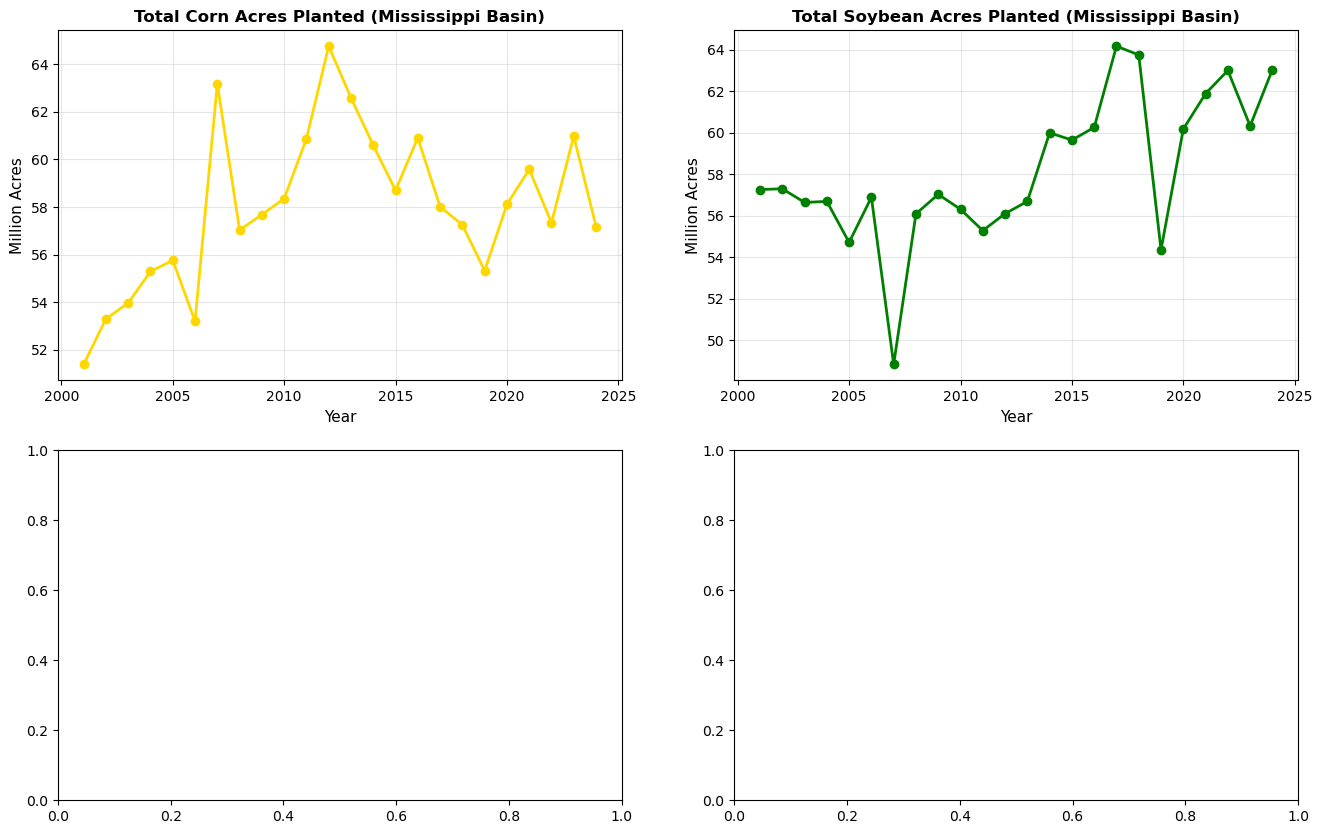

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Total corn acres over time (aggregated)
ax1 = axes[0, 0]
ax1.plot(crop_data['year'], crop_data['total_corn_acres_basin'] / 1e6, 
         marker='o', linewidth=2, color='gold', markersize=6)
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Million Acres', fontsize=11)
ax1.set_title('Total Corn Acres Planted (Mississippi Basin)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Total soybean acres over time (aggregated)
ax2 = axes[0, 1]
ax2.plot(crop_data['year'], crop_data['total_soy_acres_basin'] / 1e6, 
         marker='o', linewidth=2, color='green', markersize=6)
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Million Acres', fontsize=11)
ax2.set_title('Total Soybean Acres Planted (Mississippi Basin)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Top 5 states corn acres over time
ax3 = axes[1, 0]
top_corn_states = corn_avgs.head(5).index.tolist()
for state_col in top_corn_states:
    state_name = state_col.replace('_corn', '')
    ax3.plot(crop_data['year'], crop_data[state_col] / 1e6, 
             marker='o', linewidth=1.5, label=state_name, alpha=0.8)
ax3.set_xlabel('Year', fontsize=11)
ax3.set_ylabel('Million Acres', fontsize=11)
ax3.set_title('Top 5 Corn States', fontweight='bold', fontsize=12)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Top 5 states soybean acres over time
ax4 = axes[1, 1]
top_soy_states = soy_avgs.head(5).index.tolist()
for state_col in top_soy_states:
    state_name = state_col.replace('_soy', '')
    ax4.plot(crop_data['year'], crop_data[state_col] / 1e6, 
             marker='o', linewidth=1.5, label=state_name, alpha=0.8)
ax4.set_xlabel('Year', fontsize=11)
ax4.set_ylabel('Million Acres', fontsize=11)
ax4.set_title('Top 5 Soybean States', fontweight='bold', fontsize=12)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()


In [22]:
# Save state-level features (main modeling file)
output_file = OUTPUT_DIR / 'crop_acreage_state_level.csv'
crop_data.to_csv(output_file, index=False)

# Also save just the aggregated totals (for simple baseline models)
aggregate_only = crop_data[['year', 'total_corn_acres_basin', 'total_soy_acres_basin', 'total_crop_acres_basin']].copy()
output_file_agg = OUTPUT_DIR / 'crop_acreage_aggregated.csv'
aggregate_only.to_csv(output_file_agg, index=False)

# Save state-level raw data (for reference)
state_level = pd.concat([corn_clean, soy_clean], ignore_index=True)
output_file_state = OUTPUT_DIR / 'crop_acreage_by_state_long.csv'
state_level.to_csv(output_file_state, index=False)

# Download and Process USGS River Discharge Data
Mississippi River discharge data for hypoxia modeling
Free USGS API

In [23]:
OUTPUT_DIR = Path('Data/processed')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Key USGS monitoring stations for Mississippi River
STATIONS = {
    '07022000': {
        'name': 'Mississippi River at Thebes, IL',
        'description': 'Main stem before distributaries (captures ~90% of flow)',
        'primary': True
    },
    '07289000': {
        'name': 'Mississippi River at Vicksburg, MS', 
        'description': 'Mid-lower river, closer to Gulf',
        'primary': False
    },
    '07374000': {
        'name': 'Mississippi River at Baton Rouge, LA',
        'description': 'Just before Gulf entry',
        'primary': False
    },
    '07381490': {
        'name': 'Atchafalaya River at Simmesport, LA',
        'description': 'Major distributary (~30% of Mississippi flow)',
        'primary': False
    }
}

# Date range for hypoxia modeling
START_DATE = '2001-01-01'
END_DATE = '2024-12-31'

# USGS parameter code for discharge
DISCHARGE_PARAM = '00060'  # Discharge, cubic feet per second

In [24]:
def download_usgs_discharge(site_no, start_date, end_date, param_code='00060'):
    """
    Download daily discharge data from USGS NWIS API
    
    Parameters:
    - site_no: USGS station number
    - start_date: Start date (YYYY-MM-DD)
    - end_date: End date (YYYY-MM-DD)
    - param_code: Parameter code (00060 = discharge)
    
    Returns:
    - DataFrame with date and discharge
    """
    
    # USGS NWIS API endpoint
    base_url = "https://waterservices.usgs.gov/nwis/dv/"
    
    params = {
        'format': 'json',
        'sites': site_no,
        'startDT': start_date,
        'endDT': end_date,
        'parameterCd': param_code,
        'siteStatus': 'all'
    }
    
    try:
        print(f"\n  Downloading site {site_no}...", end=" ")
        response = requests.get(base_url, params=params, timeout=60)
        response.raise_for_status()
        
        data = response.json()
        
        # Extract time series data
        if 'value' not in data or 'timeSeries' not in data['value']:
            print("No data available")
            return None
        
        time_series = data['value']['timeSeries']
        
        if len(time_series) == 0:
            print("No data available")
            return None
        
        # Parse the data
        values = time_series[0]['values'][0]['value']
        
        dates = []
        discharge = []
        
        for item in values:
            dates.append(item['dateTime'])
            discharge.append(float(item['value']) if item['value'] != '-999999' else np.nan)
        
        df = pd.DataFrame({
            'date': pd.to_datetime(dates),
            'discharge_cfs': discharge,
            'site_no': site_no
        })
        
        print(f" {len(df)} daily records")
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Parse error: {e}")
        return None

# Download data for all stations
all_discharge_data = {}

for site_no, info in STATIONS.items():
    print(f"\n{info['name']}")
    df = download_usgs_discharge(site_no, START_DATE, END_DATE)
    
    if df is not None:
        all_discharge_data[site_no] = df
        print(f"   Date range: {df['date'].min().date()} to {df['date'].max().date()}")
        print(f"   Records: {len(df)}")
        print(f"   Missing values: {df['discharge_cfs'].isna().sum()}")

if not all_discharge_data:
    print("\nFailed to download any data!")
    raise ValueError("No discharge data available")

print(f"\n  Successfully downloaded data from {len(all_discharge_data)} stations")


Mississippi River at Thebes, IL

   Date range: 2001-01-01 to 2024-12-31
   Records: 8766
   Missing values: 0

Mississippi River at Vicksburg, MS

   Date range: 2008-01-01 to 2024-12-31
   Records: 6210
   Missing values: 0

Mississippi River at Baton Rouge, LA

   Date range: 2004-03-17 to 2024-12-31
   Records: 7594
   Missing values: 0

Atchafalaya River at Simmesport, LA

   Date range: 2009-11-13 to 2024-12-31
   Records: 5057
   Missing values: 0

  Successfully downloaded data from 4 stations


In [25]:
def process_discharge_data(df, station_name):
    """Convert daily discharge to monthly averages"""
    
    df = df.copy()
    
    # Add year and month columns
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    # Calculate monthly average discharge
    monthly = df.groupby(['year', 'month'])['discharge_cfs'].agg([
        ('mean_discharge_cfs', 'mean'),
        ('max_discharge_cfs', 'max'),
        ('min_discharge_cfs', 'min'),
        ('count', 'count')
    ]).reset_index()
    
    # Flag months with insufficient data (less than 20 days)
    monthly['complete'] = monthly['count'] >= 20
    
    # Add station identifier
    monthly['station'] = station_name
    
    return monthly

# Process each station
processed_data = {}

for site_no, df in all_discharge_data.items():
    station_info = STATIONS[site_no]
    print(f"\n{station_info['name']}:")
    
    monthly_df = process_discharge_data(df, site_no)
    processed_data[site_no] = monthly_df
    
    print(f"  Monthly records: {len(monthly_df)}")
    print(f"  Complete months: {monthly_df['complete'].sum()}")
    print(f"  Incomplete months: {(~monthly_df['complete']).sum()}")


Mississippi River at Thebes, IL:
  Monthly records: 288
  Complete months: 288
  Incomplete months: 0

Mississippi River at Vicksburg, MS:
  Monthly records: 204
  Complete months: 204
  Incomplete months: 0

Mississippi River at Baton Rouge, LA:
  Monthly records: 250
  Complete months: 249
  Incomplete months: 1

Atchafalaya River at Simmesport, LA:
  Monthly records: 169
  Complete months: 168
  Incomplete months: 1


In [26]:
# Use primary station (Thebes, IL) as main discharge variable
primary_station = '07022000'

if primary_station not in processed_data:
    print(f"Primary station {primary_station} not available, using first available station")
    primary_station = list(processed_data.keys())[0]

print(f"\nUsing primary station: {STATIONS[primary_station]['name']}")

# Get monthly data for primary station
monthly_discharge = processed_data[primary_station].copy()

# Create month names for clearer column names
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
monthly_discharge['month_name'] = monthly_discharge['month'].map(month_names)

# Pivot to wide format: one row per year, one column per month
discharge_wide = monthly_discharge.pivot(
    index='year',
    columns='month_name',
    values='mean_discharge_cfs'
)

# Reorder columns by calendar order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
discharge_wide = discharge_wide[month_order]

# Add column prefix for clarity
discharge_wide.columns = [f'discharge_{month}_cfs' for month in discharge_wide.columns]

# Reset index to make year a column
discharge_wide = discharge_wide.reset_index()

# Calculate some aggregate features
discharge_wide['discharge_annual_mean_cfs'] = monthly_discharge.groupby('year')['mean_discharge_cfs'].mean().values
discharge_wide['discharge_spring_mean_cfs'] = monthly_discharge[
    monthly_discharge['month'].isin([3, 4, 5, 6])
].groupby('year')['mean_discharge_cfs'].mean().values

print(f"\nDischarge data shape: {discharge_wide.shape}")
print(f"Years: {discharge_wide['year'].min()} to {discharge_wide['year'].max()}")
print(f"Features: {discharge_wide.shape[1] - 1} (12 monthly + 2 aggregate)")


Using primary station: Mississippi River at Thebes, IL

Discharge data shape: (24, 15)
Years: 2001 to 2024
Features: 14 (12 monthly + 2 aggregate)


In [27]:
# Check for missing values
missing_by_col = discharge_wide.isnull().sum()
if missing_by_col.sum() > 0:
    print("\nMissing values detected:")
    print(missing_by_col[missing_by_col > 0])
else:
    print("\n  No missing values!")

# Check coverage for modeling years (2001-2024)
modeling_years = set(range(2001, 2025))
available_years = set(discharge_wide['year'])
missing_years = modeling_years - available_years

if missing_years:
    print(f"\nMissing years for modeling: {sorted(missing_years)}")
else:
    print(f"\n  Complete coverage: All years 2001-2024 present")

# Summary statistics
print("\nSummary Statistics (all months in CFS):")
month_cols = [col for col in discharge_wide.columns if col.startswith('discharge_') and col.endswith('_cfs')]
print(discharge_wide[month_cols[:6]].describe().round(0))  # Show first 6 months


  No missing values!

  Complete coverage: All years 2001-2024 present

Summary Statistics (all months in CFS):
       discharge_Jan_cfs  discharge_Feb_cfs  discharge_Mar_cfs  \
count               24.0               24.0               24.0   
mean            182251.0           190657.0           282494.0   
std             113173.0            71579.0           103845.0   
min              80561.0            86943.0           119177.0   
25%             105146.0           134845.0           196605.0   
50%             130339.0           172382.0           277048.0   
75%             211331.0           245568.0           345331.0   
max             508968.0           348929.0           479323.0   

       discharge_Apr_cfs  discharge_May_cfs  discharge_Jun_cfs  
count               24.0               24.0               24.0  
mean            345864.0           419698.0           386454.0  
std             117622.0           139644.0           165476.0  
min             148067.0        

  Saved visualization: river_discharge_trends.png


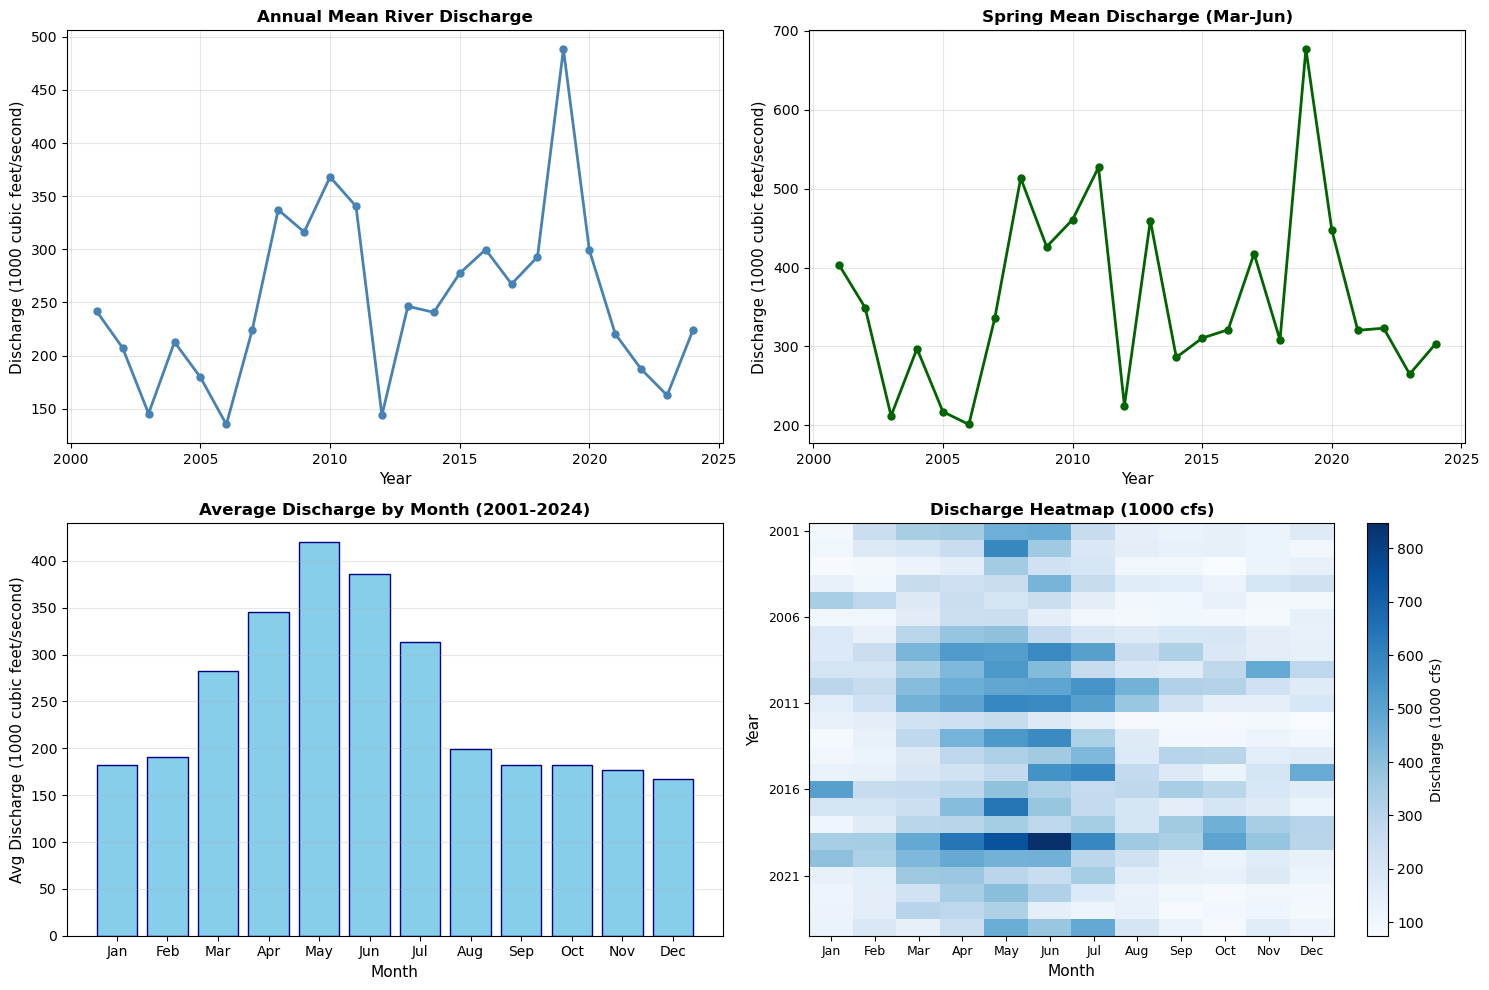

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Annual mean discharge over time
ax1 = axes[0, 0]
ax1.plot(discharge_wide['year'], discharge_wide['discharge_annual_mean_cfs'] / 1000, 
         marker='o', linewidth=2, color='steelblue', markersize=5)
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Discharge (1000 cubic feet/second)', fontsize=11)
ax1.set_title('Annual Mean River Discharge', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Spring (Mar-Jun) mean discharge over time
ax2 = axes[0, 1]
ax2.plot(discharge_wide['year'], discharge_wide['discharge_spring_mean_cfs'] / 1000, 
         marker='o', linewidth=2, color='darkgreen', markersize=5)
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Discharge (1000 cubic feet/second)', fontsize=11)
ax2.set_title('Spring Mean Discharge (Mar-Jun)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Monthly discharge patterns (average across all years)
ax3 = axes[1, 0]
monthly_avg = []
for month in month_order:
    col = f'discharge_{month}_cfs'
    monthly_avg.append(discharge_wide[col].mean())
ax3.bar(month_order, [x/1000 for x in monthly_avg], color='skyblue', edgecolor='navy')
ax3.set_xlabel('Month', fontsize=11)
ax3.set_ylabel('Avg Discharge (1000 cubic feet/second)', fontsize=11)
ax3.set_title('Average Discharge by Month (2001-2024)', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Heatmap of discharge by year and month
ax4 = axes[1, 1]
# Create matrix for heatmap
discharge_matrix = discharge_wide[[f'discharge_{m}_cfs' for m in month_order]].values / 1000
im = ax4.imshow(discharge_matrix, aspect='auto', cmap='Blues', interpolation='nearest')
ax4.set_xticks(range(12))
ax4.set_xticklabels(month_order, fontsize=9)
ax4.set_yticks(range(0, len(discharge_wide), 5))
ax4.set_yticklabels(discharge_wide['year'].values[::5], fontsize=9)
ax4.set_xlabel('Month', fontsize=11)
ax4.set_ylabel('Year', fontsize=11)
ax4.set_title('Discharge Heatmap (1000 cfs)', fontweight='bold')
plt.colorbar(im, ax=ax4, label='Discharge (1000 cfs)')

plt.tight_layout()
plt.savefig('river_discharge_trends.png', dpi=150, bbox_inches='tight')
print("  Saved visualization: river_discharge_trends.png")

In [29]:
# Save monthly discharge data (wide format - ready for modeling)
output_file = OUTPUT_DIR / 'river_discharge_monthly.csv'
discharge_wide.to_csv(output_file, index=False)
print(f"\n  Saved: {output_file}")
print(f"  Shape: {discharge_wide.shape}")
print(f"  Years: {discharge_wide['year'].min()}-{discharge_wide['year'].max()}")

# Save raw daily data (for reference)
for site_no, df in all_discharge_data.items():
    station_name = STATIONS[site_no]['name'].replace(' ', '_').replace(',', '')
    output_file_daily = OUTPUT_DIR / f'river_discharge_daily_{site_no}.csv'
    df.to_csv(output_file_daily, index=False)
    print(f"  Saved daily data: {output_file_daily}")


  Saved: Data/processed/river_discharge_monthly.csv
  Shape: (24, 15)
  Years: 2001-2024
  Saved daily data: Data/processed/river_discharge_daily_07022000.csv
  Saved daily data: Data/processed/river_discharge_daily_07289000.csv
  Saved daily data: Data/processed/river_discharge_daily_07374000.csv
  Saved daily data: Data/processed/river_discharge_daily_07381490.csv


# Process Manually Downloaded NOAA Precipitation Data

3 precipitation features per month:
  - Upper Basin (MN, WI, SD)
  - Central Basin (IA, IL, IN, OH, MO)
  - Lower Basin (AR, LA, MS, TN, KY)

In [30]:
DATA_DIR = Path('Data/Precipitation')
OUTPUT_DIR = Path('Data/processed')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Regional groupings
REGIONS = {
    'Upper': ['Minnesota', 'Wisconsin', 'South Dakota'],
    'Central': ['Iowa', 'Illinois', 'Indiana', 'Ohio', 'Missouri'],
    'Lower': ['Arkansas', 'Louisiana', 'Mississippi', 'Tennessee', 'Kentucky']
}

# Target years for modeling
TARGET_YEARS = range(2001, 2025)

In [31]:
# Find all CSV files in the directory
csv_files = list(DATA_DIR.glob('*.csv'))

In [32]:
def parse_noaa_csv(filepath):
    """
    Parse NOAA Climate at a Glance CSV file
    Handles various CSV formats from the website
    """
    
    # Read the file to find where data starts
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Find the header line (contains "Date" and "Value" or "Anomaly")
    header_idx = None
    for i, line in enumerate(lines):
        if 'Date' in line and ('Value' in line or 'Anomaly' in line):
            header_idx = i
            break
    
    if header_idx is None:
        # Try alternative: just read CSV normally
        try:
            df = pd.read_csv(filepath)
            if 'Date' in df.columns:
                header_idx = 0
            else:
                return None
        except:
            return None
    
    # Read from the header line onwards
    df = pd.read_csv(filepath, skiprows=header_idx)
    
    # Parse date column (format should be YYYYMM)
    if 'Date' not in df.columns:
        return None
    
    df['date_str'] = df['Date'].astype(str)
    
    # Extract year and month
    if len(df['date_str'].iloc[0]) >= 6:
        df['year'] = df['date_str'].str[:4].astype(int)
        df['month'] = df['date_str'].str[4:6].astype(int)
    else:
        return None
    
    # Get precipitation value (usually in "Value" column)
    value_col = None
    for col in df.columns:
        if col.lower() in ['value', 'precipitation', 'precip']:
            value_col = col
            break
    
    if value_col is None:
        # Try the second column
        value_col = df.columns[1]
    
    df['precip_inches'] = pd.to_numeric(df[value_col], errors='coerce')
    
    # Extract state name from filename
    state_name = filepath.stem
    df['state'] = state_name
    
    return df[['state', 'year', 'month', 'precip_inches']].copy()


In [33]:
# Load and parse all files
all_precip_data = []
failed_files = []

for csv_file in csv_files:
    df = parse_noaa_csv(csv_file) 
    if df is not None and len(df) > 0:
        all_precip_data.append(df)

In [34]:
# Combine all state data
precip_combined = pd.concat(all_precip_data, ignore_index=True)

# Standardize state names (capitalize properly)
state_name_map = {}
for state in precip_combined['state'].unique():
    # Try to match to expected states in regions
    state_lower = state.lower().replace('_', ' ').replace('-', ' ')
    
    for region_states in REGIONS.values():
        for expected_state in region_states:
            if expected_state.lower() == state_lower:
                state_name_map[state] = expected_state
                break
    
    # If not found, just capitalize
    if state not in state_name_map:
        state_name_map[state] = state.title()

precip_combined['state'] = precip_combined['state'].map(state_name_map)


# Filter to target years
precip_combined = precip_combined[precip_combined['year'].isin(TARGET_YEARS)].copy()


In [35]:
# Create state-to-region mapping
state_to_region = {}
for region, states in REGIONS.items():
    for state in states:
        state_to_region[state] = region

# Add region column
precip_combined['region'] = precip_combined['state'].map(state_to_region)

for region, states in REGIONS.items():
    states_present = precip_combined[precip_combined['region'] == region]['state'].unique()

# Aggregate by region and month (average across states in region)
precip_regional = precip_combined.groupby(['year', 'month', 'region'])['precip_inches'].mean().reset_index()

In [36]:
# Pivot to wide format: one row per year-month, columns for each region
precip_wide = precip_regional.pivot_table(
    index=['year', 'month'],
    columns='region',
    values='precip_inches'
).reset_index()

# Clean up column names
precip_wide.columns.name = None
region_cols = [col for col in precip_wide.columns if col not in ['year', 'month']]
precip_wide.columns = ['year', 'month'] + [f'{region}_precip_inches' for region in region_cols]

# Sort by year and month
precip_wide = precip_wide.sort_values(['year', 'month']).reset_index(drop=True)

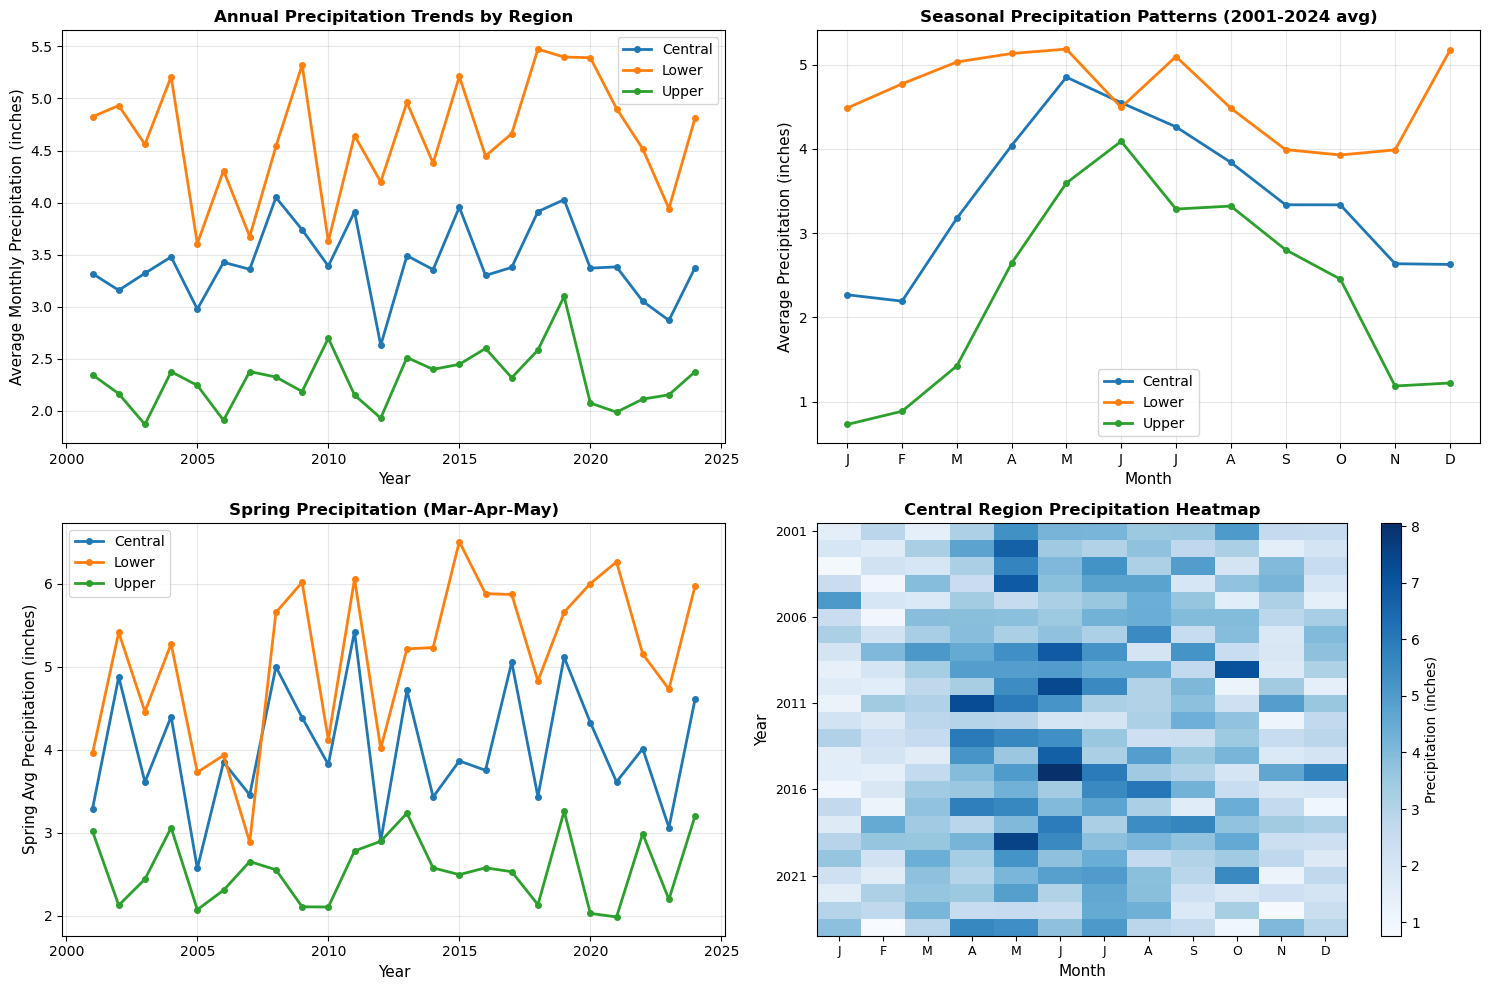

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Annual average precipitation by region
ax1 = axes[0, 0]
annual_avg = precip_regional.groupby(['year', 'region'])['precip_inches'].mean().reset_index()
for region in annual_avg['region'].unique():
    data = annual_avg[annual_avg['region'] == region]
    ax1.plot(data['year'], data['precip_inches'], marker='o', label=region, linewidth=2, markersize=4)
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Average Monthly Precipitation (inches)', fontsize=11)
ax1.set_title('Annual Precipitation Trends by Region', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Seasonal patterns (average across all years)
ax2 = axes[0, 1]
monthly_avg = precip_regional.groupby(['month', 'region'])['precip_inches'].mean().reset_index()
month_names = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
for region in monthly_avg['region'].unique():
    data = monthly_avg[monthly_avg['region'] == region]
    ax2.plot(data['month'], data['precip_inches'], marker='o', label=region, linewidth=2, markersize=4)
ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('Average Precipitation (inches)', fontsize=11)
ax2.set_title('Seasonal Precipitation Patterns (2001-2024 avg)', fontweight='bold')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(month_names)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Spring (Mar-May) precipitation over time
ax3 = axes[1, 0]
spring_precip = precip_regional[precip_regional['month'].isin([3, 4, 5])].groupby(['year', 'region'])['precip_inches'].mean().reset_index()
for region in spring_precip['region'].unique():
    data = spring_precip[spring_precip['region'] == region]
    ax3.plot(data['year'], data['precip_inches'], marker='o', label=region, linewidth=2, markersize=4)
ax3.set_xlabel('Year', fontsize=11)
ax3.set_ylabel('Spring Avg Precipitation (inches)', fontsize=11)
ax3.set_title('Spring Precipitation (Mar-Apr-May)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Heatmap of precipitation by year and month (Central region)
ax4 = axes[1, 1]
if 'Central_precip_inches' in precip_wide.columns:
    # Reshape for heatmap
    heatmap_data = precip_wide.pivot_table(
        index='year',
        columns='month',
        values='Central_precip_inches'
    )
    
    im = ax4.imshow(heatmap_data.values, aspect='auto', cmap='Blues', interpolation='nearest')
    ax4.set_xticks(range(12))
    ax4.set_xticklabels(month_names, fontsize=9)
    ax4.set_yticks(range(0, len(heatmap_data), 5))
    ax4.set_yticklabels(heatmap_data.index[::5], fontsize=9)
    ax4.set_xlabel('Month', fontsize=11)
    ax4.set_ylabel('Year', fontsize=11)
    ax4.set_title('Central Region Precipitation Heatmap', fontweight='bold')
    plt.colorbar(im, ax=ax4, label='Precipitation (inches)')

plt.tight_layout()

In [38]:
# Save wide format
output_file = OUTPUT_DIR / 'precipitation_regional_monthly.csv'
precip_wide.to_csv(output_file, index=False)

# Save state-level data (for reference/alternative models)
output_file_state = OUTPUT_DIR / 'precipitation_by_state.csv'
precip_combined.to_csv(output_file_state, index=False)

# Analyze Noaa wind data at buouy
Check temporal coverage and data quality

In [39]:
# Configuration
WIND_DIR = Path('Data/wind')
OUTPUT_DIR = Path('Data/processed')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BUOY_ID = '42040'
START_YEAR = 2001
END_YEAR = 2024

print(f"Processing NOAA Buoy {BUOY_ID} Wind Data")
print(f"Years: {START_YEAR}-{END_YEAR}")

Processing NOAA Buoy 42040 Wind Data
Years: 2001-2024


In [ ]:
def parse_buoy_file(year, buoy_id='42040'):
    """
    Parse NOAA buoy standard meteorological data file
    Missing values are coded as 99.0 or 999.0
    """
    file_path = WIND_DIR / f"{buoy_id}h{year}.txt"
    
    if not file_path.exists():
        return None
    
    try:
        # Determine format based on year
        if year >= 2007:
            # New format: Two header rows (names + units)
            # Skip the units row (row 1)
            df = pd.read_csv(file_path, delim_whitespace=True, header=0, skiprows=[1])
        else:
            # Old format: Single header row
            df = pd.read_csv(file_path, delim_whitespace=True, header=0)
        
        # Standardize column names across all formats
        col_map = {
            '#YY': 'YYYY',
            'YY': 'YYYY', 
            '#YYYY': 'YYYY',
            'WDIR': 'WD',      # 2007+ uses WDIR instead of WD
            'PRES': 'BAR',     # 2007+ uses PRES instead of BAR
            'mm': 'minute'     # 2005+ has minutes, rename to avoid conflict with MM (month)
        }
        df.rename(columns=col_map, inplace=True)
        
        # Keep only columns we need (use YYYY, MM, DD, hh for datetime)
        cols_to_keep = ['YYYY', 'MM', 'DD', 'hh', 'WD', 'WSPD', 'ATMP', 'WTMP']
        available_cols = [c for c in cols_to_keep if c in df.columns]
        
        if len(available_cols) < 4:  # At minimum need date columns
            print(f"  ✗ {year}: Insufficient columns. Available: {list(df.columns)}")
            return None
            
        df = df[available_cols].copy()
        
        # Replace missing value codes with NaN
        df.replace([99.0, 99.00, 999.0, 999.00, 9999.0], np.nan, inplace=True)
        
        # Create datetime (only using YYYY MM DD hh, ignoring minutes if present)
        df['datetime'] = pd.to_datetime(
            df[['YYYY', 'MM', 'DD', 'hh']].rename(columns={
                'YYYY': 'year',
                'MM': 'month', 
                'DD': 'day',
                'hh': 'hour'
            }),
            errors='coerce'
        )
        
        # Drop rows with invalid dates
        df = df.dropna(subset=['datetime'])
        
        # Extract year, month for grouping
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        
        return df
    
    except Exception as e:
        print(f"  ✗ Error reading {year}: {e}")
        import traceback
        traceback.print_exc()
        return None

In [41]:
all_buoy_data = []
for year in range(START_YEAR, END_YEAR + 1):
    df = parse_buoy_file(year, BUOY_ID)
    if df is not None:
        all_buoy_data.append(df)

if not all_buoy_data:
    raise ValueError("No buoy data loaded!")

# Combine all years
buoy_df = pd.concat(all_buoy_data, ignore_index=True)

Note - Claude Code helped me create the next section of code to aggregate the data to a monthly level (especially when it comes to averaging wind direction rather than just taking a simple average)

In [42]:
def calculate_wind_statistics(group):
    """
    Calculate monthly wind statistics with proper vector averaging for direction
    """

    # Wind speed statistics (simple)
    wind_speed_mean = group['WSPD'].mean()
    wind_speed_max = group['WSPD'].max()
    wind_speed_std = group['WSPD'].std()

    # Count strong wind events (>10 m/s = ~20 knots)
    # Strong winds mix water column and can reduce hypoxia
    pct_strong_winds = (group['WSPD'] > 10).sum() / len(group) * 100

    # Vector averaging for wind direction
    # Convert to radians, compute mean u/v components, convert back
    wd_rad = np.deg2rad(group['WD'].dropna())
    if len(wd_rad) > 0:
        u_component = np.mean(np.sin(wd_rad))  # East-West
        v_component = np.mean(np.cos(wd_rad))  # North-South
        mean_direction = np.rad2deg(np.arctan2(u_component, v_component))
        if mean_direction < 0:
            mean_direction += 360
    else:
        mean_direction = np.nan

    # Air and water temperature (bonus features!)
    air_temp_mean = group['ATMP'].mean()
    water_temp_mean = group['WTMP'].mean()

    # Sample count for quality assessment
    n_obs = len(group)

    return pd.Series({
        'wind_speed_mean_ms': wind_speed_mean,
        'wind_speed_max_ms': wind_speed_max,
        'wind_speed_std_ms': wind_speed_std,
        'wind_direction_mean_deg': mean_direction,
        'pct_strong_winds': pct_strong_winds,
        'air_temp_mean_C': air_temp_mean,
        'water_temp_mean_C': water_temp_mean,
        'n_observations': n_obs
    })

wind_monthly = buoy_df.groupby(['year', 'month']).apply(calculate_wind_statistics).reset_index()


In [43]:
# Save monthly wind data
output_file = OUTPUT_DIR / f'buoy_{BUOY_ID}_wind_monthly.csv'
wind_monthly.to_csv(output_file, index=False)

Note - Claude Code helped me create the next section of code to fill in missing rows/columns for the wind data

In [44]:
# Create complete year-month grid
all_months = pd.DataFrame([
    (y, m) for y in range(START_YEAR, END_YEAR + 1) for m in range(1, 13)
], columns=['year', 'month'])

# Merge to get all year-months (including missing ones)
wind_complete = all_months.merge(wind_monthly, on=['year', 'month'], how='left')

# Create a datetime index for time-based interpolation
wind_complete['date'] = pd.to_datetime(
    wind_complete['year'].astype(str) + '-' +
    wind_complete['month'].astype(str) + '-01'
)
wind_complete = wind_complete.sort_values('date').reset_index(drop=True)

# Columns to interpolate
interpolate_cols = [
    'wind_speed_mean_ms',
    'wind_speed_max_ms',
    'wind_speed_std_ms',
    'wind_direction_mean_deg',
    'pct_strong_winds',
    'air_temp_mean_C',
    'water_temp_mean_C'
]


for col in interpolate_cols:
    missing_before = wind_complete[col].isna().sum()

    if 'direction' in col:
        # Wind direction is circular - use special handling
        # Convert to radians, interpolate u/v components, convert back
        mask = wind_complete[col].notna()
        if mask.sum() > 0:
            # Get valid values
            valid_dir = wind_complete.loc[mask, col].values
            valid_idx = wind_complete.loc[mask].index

            # Convert to u/v components
            rad = np.deg2rad(valid_dir)
            u = np.sin(rad)
            v = np.cos(rad)

            # Create temporary series for interpolation
            u_series = pd.Series(index=wind_complete.index, dtype=float)
            v_series = pd.Series(index=wind_complete.index, dtype=float)
            u_series.loc[valid_idx] = u
            v_series.loc[valid_idx] = v

            # Interpolate components
            u_interp = u_series.interpolate(method='linear', limit_direction='both')
            v_interp = v_series.interpolate(method='linear', limit_direction='both')

            # Convert back to direction
            dir_interp = np.rad2deg(np.arctan2(u_interp, v_interp))
            dir_interp[dir_interp < 0] += 360

            wind_complete[col] = dir_interp

    elif 'temp' in col:
        # Temperature has strong seasonal patterns - use time-aware interpolation
        wind_complete[col] = wind_complete[col].interpolate(
            method='linear',
            limit_direction='both'
        )

    else:
        # Wind speed and stats - linear interpolation
        wind_complete[col] = wind_complete[col].interpolate(
            method='linear',
            limit_direction='both'
        )

    missing_after = wind_complete[col].isna().sum()

# Fill n_observations for interpolated months (use median)
median_obs = wind_monthly['n_observations'].median()
wind_complete['n_observations'] = wind_complete['n_observations'].fillna(median_obs)

# Drop the temporary date column
wind_complete = wind_complete.drop('date', axis=1)


# Quality check: Show some interpolated values
interpolated_mask = wind_monthly.merge(
    wind_complete[['year', 'month']],
    on=['year', 'month'],
    how='right',
    indicator=True
)['_merge'] == 'right_only'

# Replace the old wind_monthly with complete version
wind_monthly = wind_complete.copy()

# Re-save with interpolated data
output_file = OUTPUT_DIR / f'buoy_{BUOY_ID}_wind_monthly.csv'
wind_monthly.to_csv(output_file, index=False)